# Datathon AI X DATA: Vision Pillar (Spring 2025)

## Overview

### Competition Overview
The goal of this competition is to build or fine-tune a computer vision model to correctly classify sports video game images into one of five different sports genres: Basketball, Volleyball, Tennis, Soccer, and American Football. The contestants will be provided with a dataset consisting of video game images, along with a CSV file that maps the image filenames to their respective sports labels. Contestants will need to develop a model capable of identifying the sport category of each image.

## Import Libraries

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np 
import os

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50  
from tensorflow.keras.optimizers import Adam

## Data Loading and Preprocessing

### Data Loading

In [21]:
TRAIN_CSV_PATH = 'train.csv'
TEST_CSV_PATH = 'test.csv'
IMAGE_DIR = './'

In [29]:
import pandas as pd

train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

train_df.sample(10)

,filename,class,id
542,images/543.jpg,Soccer,543
784,images/785.jpg,Tennis,785
804,images/805.jpg,Volleyball,805
92,images/93.jpg,AmericanFootball,93
0,images/1.jpg,AmericanFootball,1
862,images/863.jpg,Volleyball,863
368,images/369.jpg,Basketball,369
562,images/563.jpg,Soccer,563
689,images/690.jpg,Tennis,690
819,images/820.jpg,Volleyball,820


In [23]:
train_df['class'] = train_df['class'].astype(str)
class_counts = train_df['class'].value_counts()
print("Class Counts:\n", class_counts)

Class Counts:
 class
AmericanFootball    200
Basketball          200
Soccer              200
Tennis              200
Volleyball          200
Name: count, dtype: int64


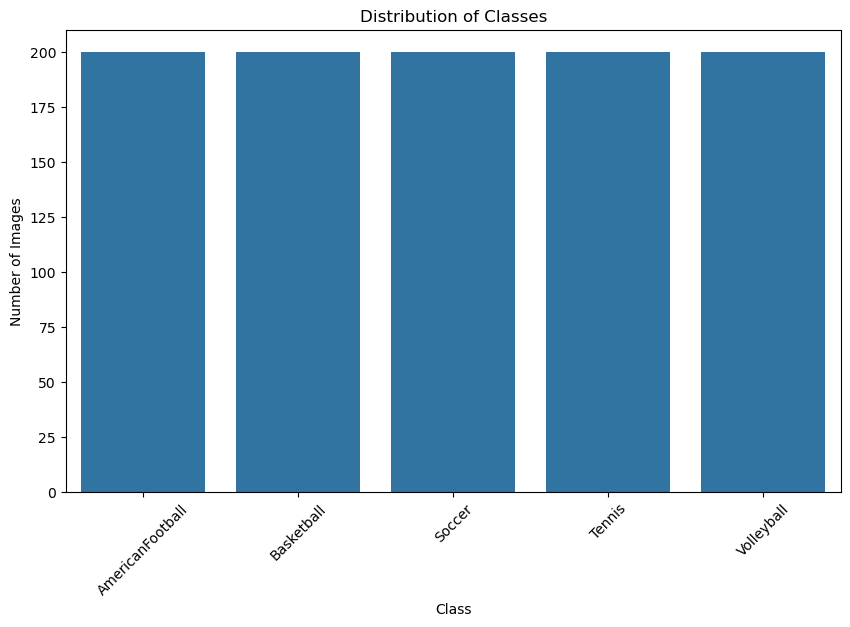

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.barplot(x=class_counts.index, y=class_counts.values)
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.show()


Displaying images for class: AmericanFootball


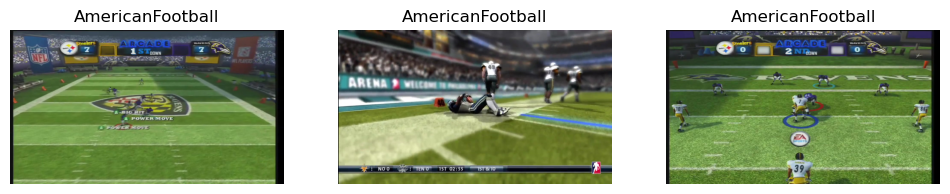

Displaying images for class: Basketball


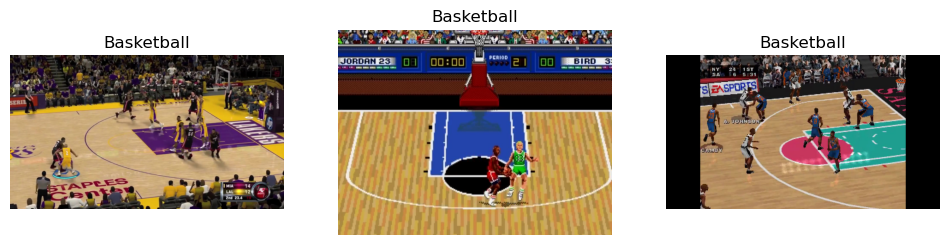

Displaying images for class: Soccer


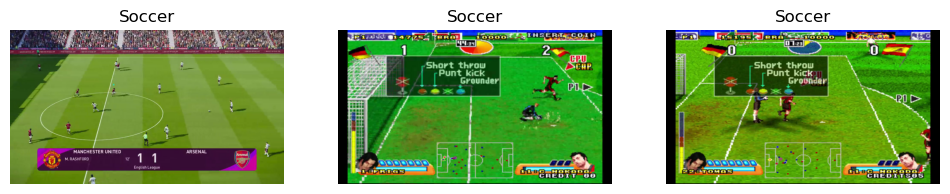

Displaying images for class: Tennis


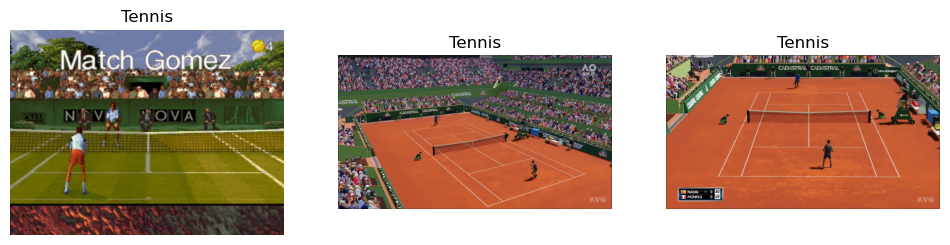

Displaying images for class: Volleyball


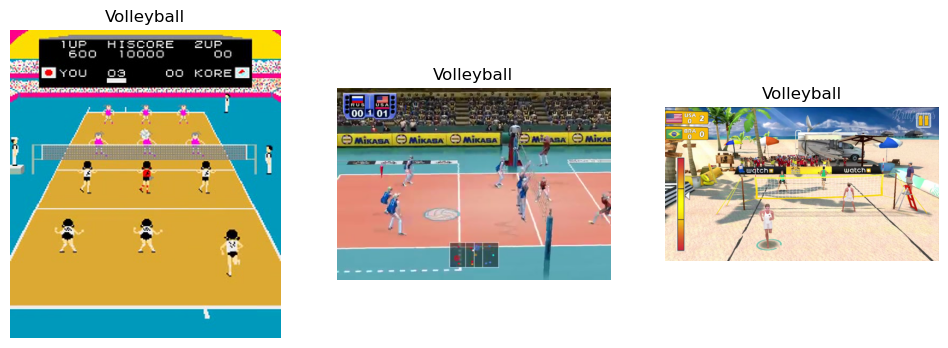

In [ ]:
from PIL import Image
import os
import matplotlib.pyplot as plt

# Get unique class names
class_names = sorted(train_df['class'].unique())

# Display a few images from each class
for class_name in class_names:
    print(f"Displaying images for class: {class_name}")
    class_images = train_df[train_df['class'] == class_name]['filename'].sample(3) 

    plt.figure(figsize=(12, 4))
    for i, image_path in enumerate(class_images):
        img = Image.open(os.path.join(IMAGE_DIR, image_path))
        plt.subplot(1, 3, i + 1)  # 1 row, 3 columns, index i+1
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')  
    plt.show()

### Data Augmention
- Prevent overfitting
- Improve generalization


In [35]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalizes pixel value, [0, 1]
    rotation_range=20,  # Randomly rotates image
    width_shift_range=0.2,  # Randomly shift images
    height_shift_range=0.2, # Randomly shift images
    shear_range=0.2, # Disorts the image
    zoom_range=0.2, # Randomly zoom
    horizontal_flip=True,  # Randomly flip images
    fill_mode='nearest' # Fill in newly created pixels 
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
BATCH_SIZE = 4  # Small batch size for easier visualization

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_DIR,
    x_col='filename',
    y_col='class',
    target_size=(224, 224), 
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True  # Shuffle is fine for visualization
)

Found 1000 validated image filenames belonging to 5 classes.


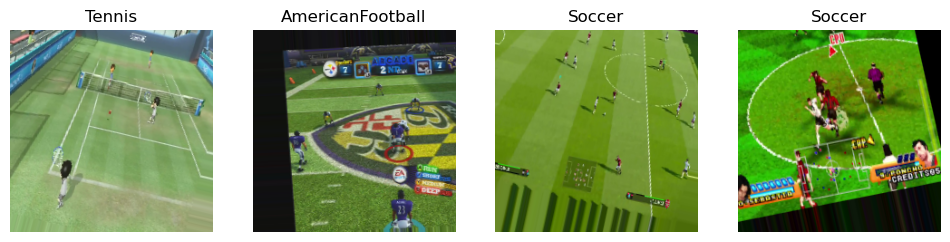

In [40]:
# Get a single batch of images and labels from the generator
images, labels = next(train_generator)

# Get class names from the generator
class_names = list(train_generator.class_indices.keys())


# Display the images in the batch
plt.figure(figsize=(12, 8))
for i in range(BATCH_SIZE):  # Iterate through the batch
    plt.subplot(1, BATCH_SIZE, i + 1)  # Create subplots
    plt.imshow(images[i])
    label_index = labels[i].argmax() #Find the index of the max value of the one-hot label
    plt.title(class_names[label_index]) 
    plt.axis('off')
plt.show()

## Model Implementation

### Model Definition

#### ResNet50 + Custom Layers

In [41]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.applications import ResNet50  
from tensorflow.keras.optimizers import Adam

IMG_HEIGHT = 224
IMG_WIDTH = 224
NUM_CLASSES = 5

# Load pre-trained ResNet50
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)  # Pool over spatial dimensions
x = Dense(1024, activation='relu')(x)  # Add a fully connected layer
predictions = Dense(NUM_CLASSES, activation='softmax')(x)  # Output layer

# Create the model
model = Model(inputs=base_model.input, outputs=predictions)

# Freeze the base model layers (initially)
for layer in base_model.layers:
    layer.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 24s 0us/step


In [43]:
LEARNING_RATE = 0.1

model.compile(optimizer=Adam(learning_rate=LEARNING_RATE),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
NUM_EPOCHS = 10

print("Starting training...")
history = model.fit(
    train_generator,
    epochs=NUM_EPOCHS,
    steps_per_epoch=train_generator.n // BATCH_SIZE,
)
print('Finished Training')